# Interact with morphologies through `neat.MorphTree`

To illustrate some of the basic functionalities of `neat.MorphTree`, we'll read in and analyze a simple ball- and stick model.

In [1]:
from neat import MorphTree, MorphNode, MorphLoc
# load the model
m_tree = MorphTree('morph/ball_and_stick.swc')

A morphology consists of nodes, that each store the 3d coordinates and radii of the segments on the morphology. A node can be accessed by its index.

In [2]:
# soma node (always index 1)
print(m_tree[1])
print(m_tree[1].xyz) # 3d coordinates
print(m_tree[1].R) # radius
# dendritic node
print(m_tree[4])
print(m_tree[4].xyz) # 3d coordinates
print(m_tree[4].R) # radius

SNode 1
[0. 0. 0.]
10.0
SNode 4
[499.   0.   0.]
1.0


Note that according to the `.swc` convention, the soma node has index 1. Morphologies should follow the three-point soma convention (<http://neuromorpho.org/SomaFormat.html>). Hence, the first dendritic node has index 4. 

Iterating over nodes is intuitive and happens in a depth firs order. By default, nodes 2 and 3 are skipped in iterations.

In [3]:
for node in m_tree: print(node)

SNode 1
SNode 4
SNode 5


We can also iterate over a subtree of the tree when we specify its root to the iterator.

In [4]:
for node in m_tree.__iter__(m_tree[4]): print(node)

SNode 4
SNode 5


## Computational tree

Solving the cable equation on a morphology is often expensive, hence, `MorphTree` defines a "computational tree" that replaces the the individual nodes between bifurcations with equivalent cylinders. A second three of lower resolution is thus defined.

In [5]:
m_tree.set_comp_tree()

The computational tree can be activated using the `MorphTree.as_computational_tree` context:

In [6]:
# let's print the nodes and their respective length and radii for both trees
with m_tree.as_computational_tree:
    print('>>> computational tree')
    for node in m_tree: print(str(node) + ', R (um) = ' + str(node.R) + ', L (um) = ' + str(node.L))
print('>>> original tree')
for node in m_tree: print(str(node) + ', R (um) = ' + str(node.R) + ', L (um) = ' + str(node.L))

>>> computational tree
SNode 1, R (um) = 10.0, L (um) = 0.0
SNode 5, R (um) = 1.0, L (um) = 1001.0
>>> original tree
SNode 1, R (um) = 10.0, L (um) = 0.0
SNode 4, R (um) = 1.0, L (um) = 499.0
SNode 5, R (um) = 1.0, L (um) = 502.0


It is important to be aware of the fact that under the hood need uses the computational tree to speed up certain calculations, but you will rarely have to set it yourself, as all functions to compute e.g. impedances, automatically set the activate the computational tree.

## Locations

Locations on a morphology are defined relative to the original node structure. A location consists of two coordinates: the node index and an $x$ $(\in [0,1])$-coordinate, specifying the relative position of the location between the node and its parent node ($x=0$ means that the location is at the parent node's 3d coordinates whereas $x=1$ means that it's at the node's coordinates). Locations are instantiated from a tuple or dictionary

In [ ]:
loc1 = MorphLoc({'node': 4, 'x': .2}) # a location close to the soma
loc2 = MorphLoc((5, .8)) # a location close to the dendritic tip

Lists of Location can also be stored under a given name. Locations in the list can be specified as tuple, dict, or `neat.MorphLoc`. Internally, they are all automatically converted to `neat.MorphLoc`s. 

In [7]:
loc1_ = {'node': 4, 'x': .2} # a location close to the soma
loc2_ = (5, .8) # a location close to the dendritic tip
m_tree.store_locs([loc1_, loc2_], name='my_favourite_locs')

Note that any NEAT function converts locations internally to :class:`MorphLoc` instances, that return the coordinates relative to the original or the computational tree, depending on which one is active. 
Locations can be retrieved as well (note that they are returned as :class:`MorphLoc` instances).

In [8]:
locs = m_tree.get_locs('my_favourite_locs')
# returned as MorphLoc instances
print(isinstance(locs[0], MorphLoc))
# always print the original coordinates
print(locs[0])
# but returned coordinate value depends on the active tree
print('original', locs[0]['node'], locs[0]['x'])
with m_tree.as_computational_tree:
    print('computational', locs[0]['node'], locs[0]['x'])

[{'node': 4, 'x': 0.20 }, {'node': 5, 'x': 0.80 }]
{'node': 4, 'x': 0.20 }
original 4 0.2
computational 5 0.09970029970029971


Locations can also easily be compared, where the comparison operator takes into account whether the locations are topologically the same.

In [9]:
MorphLoc((4, 1.)) == MorphLoc((5, 0.))

1

A number of functions are implemented that distribute locations on the morphology (`MorphTree.distribute_locs_at_d2s()`, `MorphTree.distribute_locs_uniform()`, `MorphTree.distribute_locs_random()`). We refer to the documentation for their specific uses. For now we'll distribute a set of locations uniformly on the morphology with a spacing of approximately 4 $\mu$m.

In [10]:
locs = m_tree.distribute_locs_uniform(dx=4.)

We can also evaluate the path length (the length of the shortest path, in $\mu$m) between locations:

In [11]:
print(m_tree.path_length(locs[0], locs[1]))

4.0040000000000004


## Nodearg

To look at the more advanced functionality of `MorphTree`, we'll read in a real morphology

In [12]:
m_tree = MorphTree('morph/N19ttwt.CNG.swc')
m_tree.set_comp_tree()

In NEAT, functions that run over a set of nodes require a `node_arg`, which specifies which set of nodes. For all it's uses, we refer to the documentation of `MorphTree.convert_node_arg_to_nodes()`. Now, we'll use it to distribute locations uniformly on the subtree of node 76.

In [13]:
subtree_locs = m_tree.distribute_locs_uniform(dx=15., node_arg=m_tree[74], name='subtree')

Note that this set of locations is stored under the name `'subtree'`

## Plotting

We can plot 2D projections of the morphology with `MorphTree.plot_2d_morphology()`. This function has many options, we'll use this function to plot the morphology of the granule cell in combination with the locations defined before.

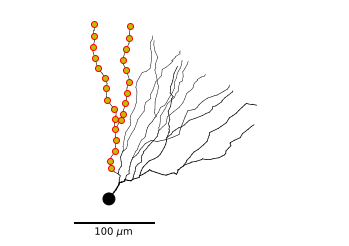

In [14]:
import matplotlib.pyplot as pl
pl.figure()
ax = pl.gca() # axes object needs to be passed to NEAT plot function
m_tree.plot_2d_morphology(ax, marklocs=subtree_locs, loc_args=dict(marker='o', mec='r', mfc='y'))
pl.show()

We can also unravel the morphology on a 1 dimensional axis (depth-first ordering). That way we can visualize the value of field defined on the morphology (such as membrance voltage).

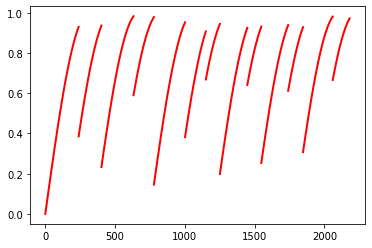

In [15]:
# We have to define a set of locations on the morphology at which the function is evaluated (here dx ~ 4 um)
m_tree.make_x_axis(4.)
# create a function
import numpy as np
d2s = m_tree.distances_to_soma('xaxis') # the distances to the soma (in um) of the locations stored under 'xaxis'
y_arr = np.sin(d2s/200.) # function to be plotted
# plot the function
ax = pl.figure().gca()
m_tree.plot_1d(ax, y_arr, lw='2', c='r') # we can use the same keyword arguments as for the matplotlib plot function
pl.show()

As such, it is not very clear which x-value corresponds with which location on the morphology. To remedy this, we can color each branch of the morphology differently and color the x-axis accordingly.

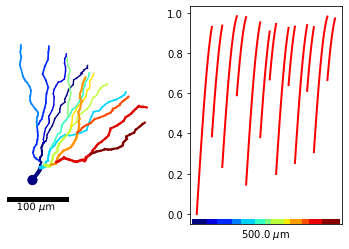

In [16]:
from matplotlib import cm
pl.figure()
ax1 = pl.subplot(121); ax2 = pl.subplot(122)
# to color the x-axis, node colors have to be set first
m_tree.set_node_colors()
# plot the morphology with associated colors
m_tree.plot_2d_morphology(ax1, cs='x_color', cmap=pl.get_cmap('jet'), plotargs={'lw':3})
# plot the function
m_tree.plot_1d(ax2, y_arr, lw='2', c='r') 
# color the x-axis of the plot according to the branch where each location is situated 
m_tree.color_x_axis(ax2, cmap=pl.get_cmap('jet'))

Note that `MorphTree.color_x_axis()` gets its y-coordinates for the colored line as the axes limits. If the limits are changed after the colored axis is added, this may result in funky position for the colored line. Hence, only call this function after all lines are added to the plot.

We can also plot fields defined on the morphology as a function of the distance to the soma.

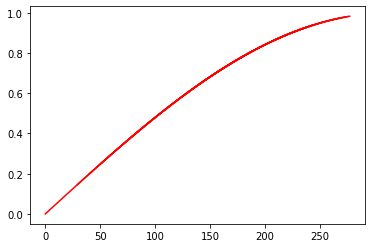

In [17]:
ax = pl.figure().gca()
m_tree.plot_true_d2s(ax, y_arr, c='r')
pl.show()


Note that here we only see a single line as our field is only a function of the distance to the soma.

Finally, we may want to select a custom set of locations on the morphology. To get the node indices, NEAT implements an interactive plot function that, when one clicks on a location of the morphology, the indices of nearby nodes are printed as well as their distances to the soma (although the interactive part does not seem to run in the notebook, but it works when you just run python).

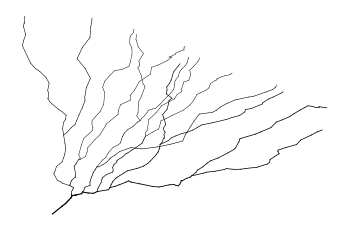

In [18]:
m_tree.plot_morphology_interactive()

## Resampling

Some applications may require a resampling of the tree. A tree can be resampled starting from any given set of locations (although low resolution sets may give funny results). The positions of the nodes of the new tree in 3d space will then correspond to positions of the locations on the old tree. Note that the soma or the original tree is added by default, even if it is not in the set of locations.

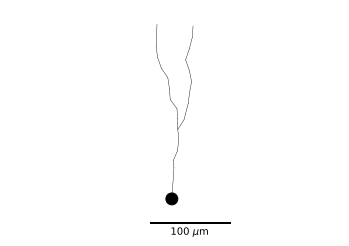

In [19]:
# create the resampled tree
m_tree_resampled = m_tree.create_new_tree('subtree')
# plot the resampled tree
ax = pl.figure().gca()
m_tree_resampled.plot_2d_morphology(ax)
pl.show()